# Risk & Finance Management - Kelompok 9

## Import Library

In [1]:
# Import Library

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

print("Library berhasil di import")

Library berhasil di import


## Import Data

In [2]:
df = pd.read_csv("..\Loan_status_2007-2020Q3.csv")

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\User\AppData\Local\Temp\ipykernel_22488\454743730.py:1: SyntaxWarning: invalid escape sequence '\L'
  df = pd.read_csv("..\Loan_status_2007-2020Q3.csv")
C:\Users\User\AppData\Local\Temp\ipykernel_22488\454743730.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("..\Loan_status_2007-2020Q3.csv")


In [3]:
needed_columns = [
    "loan_amnt",
    "term",
    "int_rate",
    "installment",
    "grade",
    "sub_grade",
    "emp_length",
    "home_ownership",
    "issue_d",
    "verification_status",
    "purpose",
    "dti",
    "delinq_2yrs",
    "loan_status",
    "zip_code",
    "avg_cur_bal",
    "revol_bal",
]
df = df[needed_columns]
print(df.head())

   loan_amnt        term int_rate  installment grade sub_grade emp_length  \
0     5000.0   36 months   10.65%       162.87     B        B2  10+ years   
1     2500.0   60 months   15.27%        59.83     C        C4   < 1 year   
2     2400.0   36 months   15.96%        84.33     C        C5  10+ years   
3    10000.0   36 months   13.49%       339.31     C        C1  10+ years   
4     3000.0   60 months   12.69%        67.79     B        B5     1 year   

  home_ownership   issue_d verification_status         purpose    dti  \
0           RENT  Dec-2011            Verified     credit_card  27.65   
1           RENT  Dec-2011     Source Verified             car   1.00   
2           RENT  Dec-2011        Not Verified  small_business   8.72   
3           RENT  Dec-2011     Source Verified           other  20.00   
4           RENT  Dec-2011     Source Verified           other  17.94   

   delinq_2yrs  loan_status zip_code  avg_cur_bal  revol_bal  
0          0.0   Fully Paid    860x

## Pre-Processing

In [4]:
df = df.dropna()
print("\nNull value count")
for col in needed_columns:
    print("{} = {}".format(col, df[col].isnull().sum()))


Null value count
loan_amnt = 0
term = 0
int_rate = 0
installment = 0
grade = 0
sub_grade = 0
emp_length = 0
home_ownership = 0
issue_d = 0
verification_status = 0
purpose = 0
dti = 0
delinq_2yrs = 0
loan_status = 0
zip_code = 0
avg_cur_bal = 0
revol_bal = 0


In [5]:
## Interest rate
df["int_rate"] = df["int_rate"].str.replace("%", "").str.strip().astype(float)

## Term
df["term"] = df["term"].str.replace("months", "").str.strip().astype(int)

In [6]:
print(df.head())

       loan_amnt  term  int_rate  installment grade sub_grade emp_length  \
42536    12000.0    36     10.99       392.81     B        B2    4 years   
42537     4800.0    36     10.99       157.13     B        B2    2 years   
42538    27050.0    36     10.99       885.46     B        B2  10+ years   
42539    12000.0    36      7.62       373.94     A        A3    3 years   
42540    14000.0    36     12.85       470.71     B        B4    4 years   

      home_ownership   issue_d verification_status             purpose    dti  \
42536           RENT  Dec-2013        Not Verified  debt_consolidation   4.62   
42537       MORTGAGE  Dec-2013     Source Verified    home_improvement   2.49   
42538            OWN  Dec-2013            Verified  debt_consolidation  22.87   
42539       MORTGAGE  Dec-2013        Not Verified  debt_consolidation  12.61   
42540           RENT  Dec-2013        Not Verified  debt_consolidation  10.02   

       delinq_2yrs loan_status zip_code  avg_cur_bal  re

## Exploratory Data Analysis

<Axes: title={'center': 'Loan Status Values for Lending Club'}, ylabel='loan_status'>

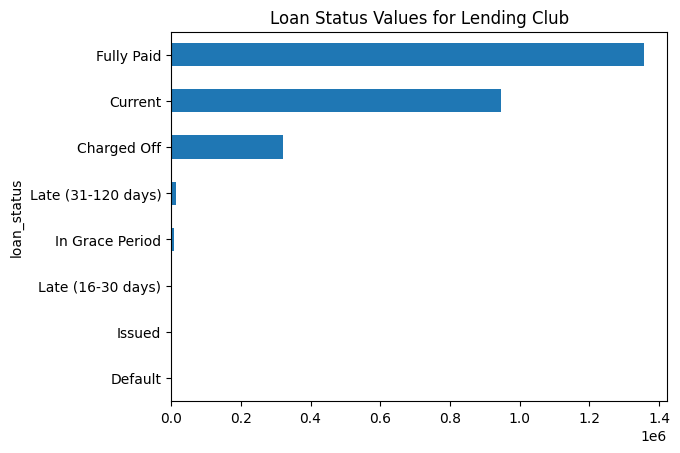

In [7]:
df["loan_status"].dropna().value_counts().sort_values().plot(
    kind="barh", title="Loan Status Values for Lending Club"
)

<Axes: title={'center': 'Loan Grades for Lending Club'}, ylabel='grade'>

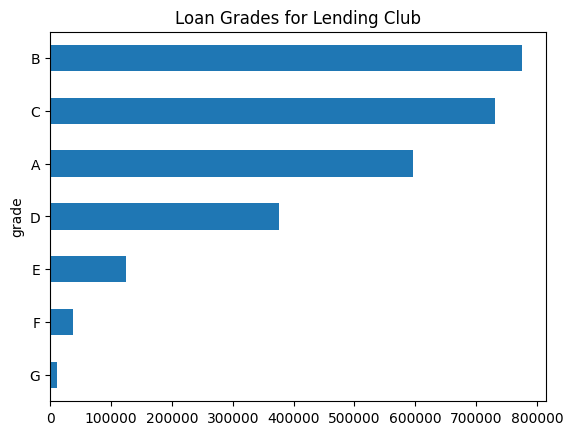

In [8]:
df["grade"].value_counts().sort_values().plot(
    kind="barh", title="Loan Grades for Lending Club"
)

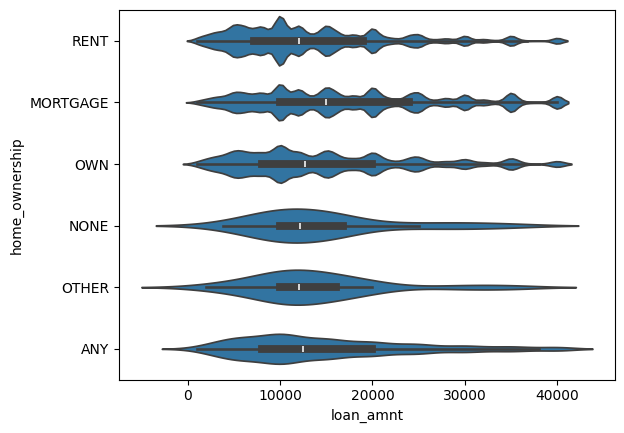

In [9]:
sns.violinplot(x="loan_amnt", y="home_ownership", data=df)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

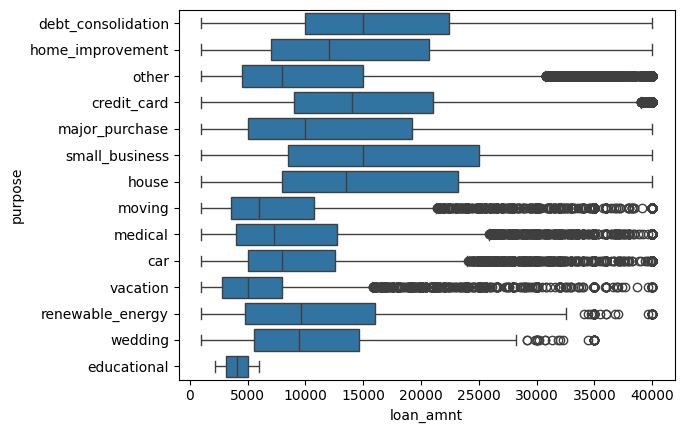

In [10]:
sns.boxplot(x="loan_amnt", y="purpose", data=df)
plt.show

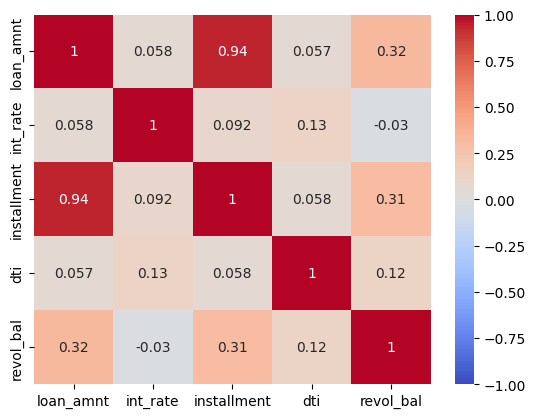

In [11]:
numeric_df = df[["loan_amnt", "int_rate", "installment", "dti", "revol_bal"]]
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [20]:
df["loan_status"] = df["loan_status"].apply(lambda status: 'Yes' if status in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)'] else 'No')

In [21]:
le = LabelEncoder()
df["emp_length"] = le.fit_transform(df["emp_length"])
df["grade"] = le.fit_transform(df["grade"])
df["sub_grade"] = le.fit_transform(df["sub_grade"])
df["home_ownership"] = le.fit_transform(df["home_ownership"])
df["issue_d"] = le.fit_transform(df["issue_d"])
df["verification_status"] = le.fit_transform(df["verification_status"])
df["purpose"] = le.fit_transform(df["purpose"])
df["loan_status"] = le.fit_transform(df["loan_status"])
df["zip_code"] = le.fit_transform(df["zip_code"])

## Modelling

### Imbalance Handling and Data Splitting

In [16]:
print("Distribusi 'Loan Status' sebelum pembagian data:", df["loan_status"].value_counts())

X = df.drop("loan_status", axis=1)  # Features
y = df["loan_status"]  # Target variable

def split_and_balance(X, y, test_ratio, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=random_state, stratify=y
    )
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    return X_train_balanced, X_test, y_train_balanced, y_test

splits = {"8:2": 0.2, "7:3": 0.3, "6:4": 0.4}
datasets = {}

for split_name, test_ratio in splits.items():
    X_train_balanced, X_test, y_train_balanced, y_test = split_and_balance(X, y, test_ratio)

    datasets[split_name] = {
        "X_train": X_train_balanced,
        "X_test": X_test,
        "y_train": y_train_balanced,
        "y_test": y_test,
    }
    
    print(f"Distribusi Loan Status pada data latih ({split_name}):", pd.Series(y_train_balanced).value_counts())
    print(f"Distribusi Loan Status pada data uji ({split_name}):", y_test.value_counts())


Distribusi 'Loan Status' sebelum pembagian data: loan_status
0    2312769
1     338923
Name: count, dtype: int64
Distribusi Loan Status pada data latih (8:2): loan_status
0    1850215
1    1850215
Name: count, dtype: int64
Distribusi Loan Status pada data uji (8:2): loan_status
0    462554
1     67785
Name: count, dtype: int64
Distribusi Loan Status pada data latih (7:3): loan_status
0    1618938
1    1618938
Name: count, dtype: int64
Distribusi Loan Status pada data uji (7:3): loan_status
0    693831
1    101677
Name: count, dtype: int64
Distribusi Loan Status pada data latih (6:4): loan_status
0    1387661
1    1387661
Name: count, dtype: int64
Distribusi Loan Status pada data uji (6:4): loan_status
0    925108
1    135569
Name: count, dtype: int64


In [ ]:
def plot_confusion_matrix(y_true, y_pred, split_name, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ya", "Tidak"], yticklabels=["Ya", "Tidak"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix {model_name} - Split {split_name}")
    plt.show()

In [29]:
def evaluate_model(y_true, y_pred, split_name, model_name):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1-score": f1_score(y_true, y_pred, average="weighted"),
    }
    print(f"\nEvaluasi Model {model_name} untuk Split {split_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    return metrics

### Decision Tree

Decision Tree

Evaluasi Model Decision Tree untuk Split 8:2:
Accuracy: 0.7803
Precision: 0.7993
Recall: 0.7803
F1-score: 0.7893


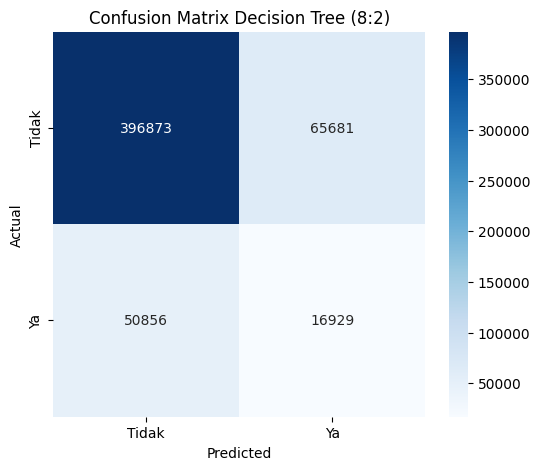

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87    462554
           1       0.20      0.25      0.23     67785

    accuracy                           0.78    530339
   macro avg       0.55      0.55      0.55    530339
weighted avg       0.80      0.78      0.79    530339


Evaluasi Model Decision Tree untuk Split 7:3:
Accuracy: 0.7795
Precision: 0.7990
Recall: 0.7795
F1-score: 0.7887


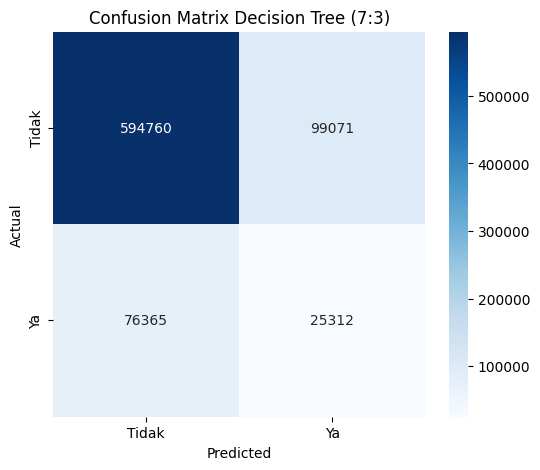

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87    693831
           1       0.20      0.25      0.22    101677

    accuracy                           0.78    795508
   macro avg       0.54      0.55      0.55    795508
weighted avg       0.80      0.78      0.79    795508


Evaluasi Model Decision Tree untuk Split 6:4:
Accuracy: 0.7776
Precision: 0.7985
Recall: 0.7776
F1-score: 0.7875


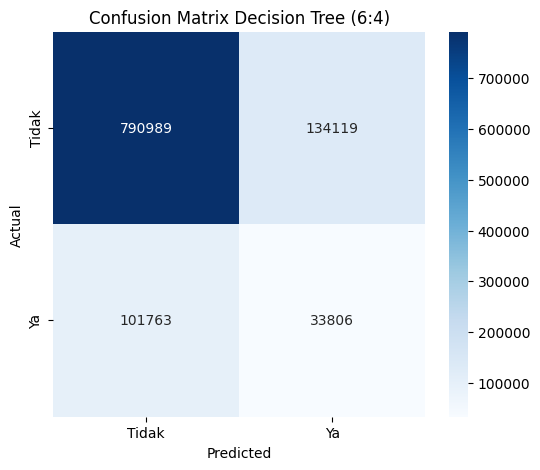

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87    925108
           1       0.20      0.25      0.22    135569

    accuracy                           0.78   1060677
   macro avg       0.54      0.55      0.55   1060677
weighted avg       0.80      0.78      0.79   1060677



In [37]:
print("Decision Tree")

for split_name, data in datasets.items():
    X_train, X_test = data["X_train"], data["X_test"]
    y_train, y_test = data["y_train"], data["y_test"]

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)

    evaluate_model(y_test, y_pred_dt, split_name, "Decision Tree")
    plot_confusion_matrix(y_test, y_pred_dt, title=f"Confusion Matrix Decision Tree ({split_name})")
    print("Decision Tree Classification Report ({split_name}):\n", classification_report(y_test, y_pred_dt))

### Random Forest

In [ ]:
print("Random Forest")

for split_name, data in datasets.items():
    X_train, X_test = data["X_train"], data["X_test"]
    y_train, y_test = data["y_train"], data["y_test"]
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    evaluate_model(y_test, y_pred_rf, split_name, "Random Forest")
    plot_confusion_matrix(y_test, y_pred_rf, title=f"Confusion Matrix Random Forest ({split_name})")
    print("Random Forest Classification Report ({split_name}):\n", classification_report(y_test, y_pred_rf))

Random Forest


### XGBoost

In [ ]:
print("XGBoost")

for split_name, data in datasets.items():
    X_train, X_test = data["X_train"], data["X_test"]
    y_train, y_test = data["y_train"], data["y_test"]

    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    evaluate_model(y_test, y_pred_xgb, split_name, "XGBoost")
    plot_confusion_matrix(y_test, y_pred_xgb, title=f"Confusion Matrix XGBoost ({split_name})")
    print("XGBoost Classification Report ({split_name}):\n", classification_report(y_test, y_pred_xgb))

### Logistic Regression

In [30]:
print("Logisctic Regression")

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

D:\Program Files\PythonUserPackages\Python313\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Precision:", precision_lr)
print("Logistic Regression Recall:", recall_lr)
print("Logistic Regression F1-Score:", f1_lr)

Logistic Regression Accuracy: 0.870545613620479
Logistic Regression Precision: 0.40952737249033544
Logistic Regression Recall: 0.032344801095231995
Logistic Regression F1-Score: 0.05995435874030123


In [32]:
print(
    "Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr)
)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93    693977
           1       0.41      0.03      0.06    101531

    accuracy                           0.87    795508
   macro avg       0.64      0.51      0.50    795508
weighted avg       0.82      0.87      0.82    795508



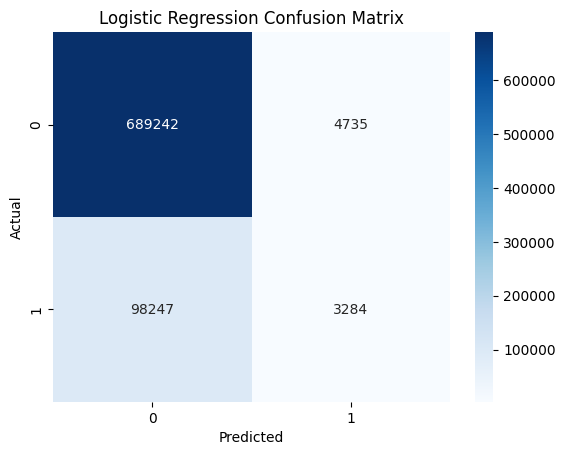

In [33]:
cm_dt = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()